# WAVYTROPICS Practical Session 1

<center> <img src = Fadhil_1.png width = "700" height = "300" > </center>



# Introduction

<!-- <center> <img src = WavyTropicsLogo_2.png width = "300" height = "300" > </center> -->

Author: **Fadhlil R. Muhammad**

ORCID: https://orcid.org/0000-0003-1250-4663

Affiliation: **The University of Melbourne**

Welcome to day 1 of wavytropics practical session. In this notebook, you will learn how to:

1. Get the real-time multivariate MJO index (RMM) for the MJO activity.
2. Get the outgoing longwave radiation (OLR) data and calculate the daily anomalies.
3. Choose the seasons in the data and list dates for each phase of the MJO.
4. Create OLR anomaly composites for the MJO.

In addition:
1. Get the index for ENSO and pair it with the MJO index.
2. Create OLR anomaly composites during the La-Nina/El-Nino for each phase of the MJO.

The OLR data acts as the proxy for convection. A high negative anomaly indicates a deep convection and vice versa. In this notebook, we will plot the composites for each phase and compare the MJO convective activity during El-Nino/La-Nina vs All days.

*Disclaimer: This module is for educational purposes only and is intended as a starting point towards more understanding about the topic.*


## Stage 1: Preparing data, data clean-up, and constructing the MJO phase diagram

First, we import the required packages.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import dask

from my_package import plot_composites, low_pass_weights, band_pass
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')


mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.minor.width'] = 0.5

Now, we load the real-time multivariate MJO index (RMM). The data is obtained from the Bureau of Meteorology (BoM) Australia website (http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt). 

The RMM index is made from the principal component (PC) using the empirical orthogonal function analysis (EOF) over the tropical band (Wheeler and Hendon 2004). With this diagram, the activity of the MJO can be monitored relatively easily. The diagram comprises of eight phases, which indicate the geographical location of the MJO convective center. For details, it is recommended that you read this amazing paper by Wheeler and Hendon (2004) (http://www.bom.gov.au/climate/mjo/about/WH04.pdf).

The amplitude of the MJO can be defined as:
$$
  MJO_{amp} = \sqrt{RMM1^2 + RMM2^2}
$$

a weak MJO is when $MJO_{amp}$ is less than one. In the diagram, the weak MJO is located inside the circle in the center of the diagram.


<center> <img src = http://www.bom.gov.au/climate/mjo/graphics/rmm.phase.Last40days.gif width = "400" height = "400" > </center>

Now, we will try to plot our own phase diagram and make OLR anomaly composites using these pieces of information.

Load the data

In [2]:
url_rmm  = "rmm.74toRealtime.txt"    #get the data
rmm_csv = pd.read_csv(url_rmm,                        
                      sep       = "\s+",           #string separator
                      skiprows  = 1,               #skip the first row (it's only comments about the data, we don't need that)
                     )

rmm_csv #show the dataset

year,  month,  day,     RMM1,     RMM2,  phase,  amplitude.  \
0       1974       6     1  1.634470  1.203040       5    2.029480   
1       1974       6     2  1.602890  1.015120       5    1.897290   
2       1974       6     3  1.516250  1.085510       5    1.864760   
3       1974       6     4  1.509810  1.035730       5    1.830920   
4       1974       6     5  1.559060  1.305180       5    2.033260   
...      ...     ...   ...       ...       ...     ...         ...   
18043   2023      10    25 -0.759337  1.216706       7    1.434212   
18044   2023      10    26 -0.793645  1.177280       7    1.419810   
18045   2023      10    27 -0.882120  0.989530       7    1.325634   
18046   2023      10    28 -0.874455  0.638592       8    1.082807   
18047   2023      10    29 -0.958383  0.274404       8    0.996893   

                               Missing  Value=  1.E36  or  999  
0       Final_value:__OLR_&_NCEP_winds     NaN    NaN NaN  NaN  
1       Final_value:__OLR_&_NCEP_winds     NaN    NaN NaN  NaN  
2       Final_value:__OLR_&_NCEP_winds     NaN    NaN NaN  NaN  
3       Final_value:__OLR_&_NCEP_winds     NaN    NaN NaN  NaN  
4       Final_value:__OLR_&_NCEP_winds     NaN    NaN NaN  NaN  
...                                ...     ...    ...  ..  ...  
18043  Prelim_value:_OLR_&_ACCESS_wind     NaN    NaN NaN  NaN  
18044  Prelim_value:_OLR_&_ACCESS_wind     NaN    NaN NaN  NaN  
18045  Prelim_value:_OLR_&_ACCESS_wind     NaN    NaN NaN  NaN  
18046  Prelim_value:_OLR_&_ACCESS_wind     NaN    NaN NaN  NaN  
18047  Prelim_value:_OLR_&_ACCESS_wind     NaN    NaN NaN  NaN  

[18048 rows x 12 columns]

We can see the header is a bit messy. Now, we clean up the header a little and slice the table to get only what we need.

In [3]:
#this function is to rename the header
rmm_csv = rmm_csv.rename(columns={'year,' : 'year', 
                                  'month,': 'month',
                                  'day,'  : 'day',
                                  'RMM1,' : 'RMM1',
                                  'RMM2,' : 'RMM2',
                                  'phase,': 'phase',
                                  'amplitude.' : 'amplitude',
                                 }
                        )

#get only what we need
rmm_csv = rmm_csv[["year","month","day", "RMM1", "RMM2", "amplitude"]]

#splice the year from 1981 - 2018
rmm_csv = rmm_csv.loc[(rmm_csv["year"]>=1981) & (rmm_csv["year"]<=2018)]

rmm_csv

year  month  day      RMM1      RMM2  amplitude
2406   1981      1    1 -0.342760 -0.737290   0.813072
2407   1981      1    2 -0.067393 -0.850890   0.853555
2408   1981      1    3  0.229987 -0.412600   0.472373
2409   1981      1    4  0.243862  0.019839   0.244668
2410   1981      1    5  0.436574  0.416489   0.603374
...     ...    ...  ...       ...       ...        ...
16280  2018     12   27  2.854728  1.061975   3.045860
16281  2018     12   28  2.554292  1.038218   2.757228
16282  2018     12   29  2.225662  1.079722   2.473736
16283  2018     12   30  1.976675  1.320823   2.377355
16284  2018     12   31  1.841697  1.680729   2.493331

[13879 rows x 6 columns]

It looks much better now!

Now, we split the data into two seasons: extended winter (NDJFMA) or extended summer (MJJASO). I also give the code for other seasons as well, you just need to uncomment the lines.

In [4]:
rmm_all = rmm_csv.copy()   #copy the rmm data

season="DJF"

if season == "NDJFMA":
    rmm_season = rmm_all.loc[(rmm_all["month"] >= 11) | (rmm_all["month"] <= 4)]
elif season == "MJJASO":
    rmm_season = rmm_all.loc[(rmm_all["month"] >= 5) & (rmm_all["month"] <= 10)]
elif season == "DJF":
    rmm_season = rmm_all.loc[(rmm_all["month"] >= 12) | (rmm_all["month"] <= 2)]
elif season == "MAM":
    rmm_season = rmm_all.loc[(rmm_all["month"] >= 3) & (rmm_all["month"] <= 5)]
elif season == "JJA":
    rmm_season = rmm_all.loc[(rmm_all["month"] >= 6) & (rmm_all["month"] <= 8)]
elif season == "SON":
    rmm_season = rmm_all.loc[(rmm_all["month"] >= 9) & (rmm_all["month"] <= 11)]
    
rmm_season

year  month  day      RMM1      RMM2  amplitude
2406   1981      1    1 -0.342760 -0.737290   0.813072
2407   1981      1    2 -0.067393 -0.850890   0.853555
2408   1981      1    3  0.229987 -0.412600   0.472373
2409   1981      1    4  0.243862  0.019839   0.244668
2410   1981      1    5  0.436574  0.416489   0.603374
...     ...    ...  ...       ...       ...        ...
16280  2018     12   27  2.854728  1.061975   3.045860
16281  2018     12   28  2.554292  1.038218   2.757228
16282  2018     12   29  2.225662  1.079722   2.473736
16283  2018     12   30  1.976675  1.320823   2.377355
16284  2018     12   31  1.841697  1.680729   2.493331

[3429 rows x 6 columns]

Then, create a column named 'yyyymmdd' to store the dates

In [5]:
yyyymmdd  = rmm_season["year"].astype(str) + "-" +\
            rmm_season["month"].astype(str).str.zfill(2) + "-" +\
            rmm_season["day"].astype(str).str.zfill(2)

In [6]:
#move the column to the left
rmm_season.insert(0,'yyyymmdd',yyyymmdd.astype('str'))

In [7]:
#drop the 'year', 'month', and 'day' columns
rmm_season = rmm_season.drop(['year', 'month','day'], axis=1)

We can try to plot our own MJO phase diagram. The example is as follows:

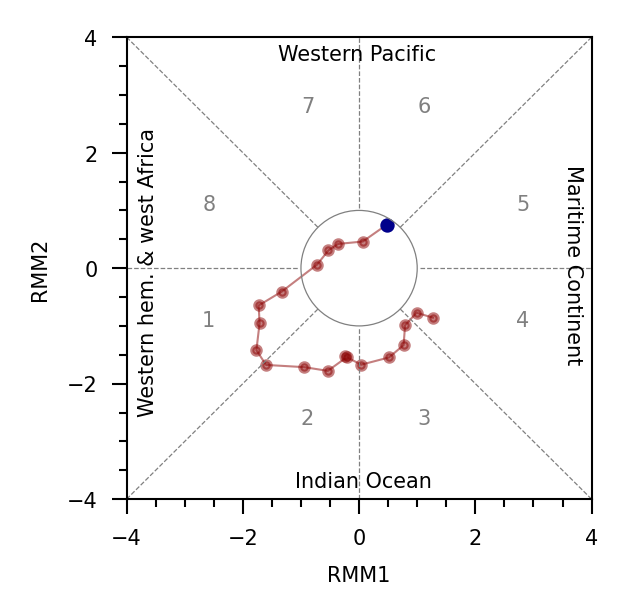

In [8]:
#assign the x and y value of the plot
x_plot = rmm_season["RMM1"].loc[(rmm_season["yyyymmdd"] >= "2017-01-12") & (rmm_season["yyyymmdd"] <= "2017-01-31")]
y_plot = rmm_season["RMM2"].loc[(rmm_season["yyyymmdd"] >= "2017-01-12") & (rmm_season["yyyymmdd"] <= "2017-01-31")]


#plotting functions, modify it as you please :)
weak_mjo_area = plt.Circle((0, 0), 1., color='gray', lw=0.3,fill=False)

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

ax.plot(x_plot, y_plot,
        color  = "darkred",
        marker = "o",
        alpha  = 0.5,
        markersize=2,
        linewidth = 0.5,
        zorder = 0,
          )

ax.scatter(x_plot.iloc[0], y_plot.iloc[0], marker='o', s=6 ,color='darkblue',zorder=1)

ax.set(xlim=(-4, 4), xticks=np.arange(-4, 4.1),
       ylim=(-4, 4), yticks=np.arange(-4, 4.1))

#remove grid
ax.grid(False)

#make the design for RMM plot
#draw MJO weak region (circle in the middle with r=1)
ax.add_patch(weak_mjo_area)

#draw line for phase division
#horizontal
ax.axhline(y = 0, xmin=0, xmax=0.37, color = 'gray', linestyle = '--', lw=0.3) 
ax.axhline(y = 0, xmin=1-0.37, xmax=1, color = 'gray', linestyle = '--', lw=0.3) 
#vertical
ax.axvline(x = 0, ymin=1-0.37, ymax=1, color = 'gray', linestyle = '--', lw=0.3) 
ax.axvline(x = 0, ymin=0, ymax=0.37, color = 'gray', linestyle = '--', lw=0.3) 
#diagonal
ax.plot((-4, -0.7), (-4, -0.7), color = 'gray', linestyle = '--', lw=0.3)
ax.plot((4, 0.7), (4, 0.7), color = 'gray', linestyle = '--', lw=0.3)
ax.plot((4, 0.7), (-4, -0.7), color = 'gray', linestyle = '--', lw=0.3)
ax.plot((-4, -0.7), (4, 0.7), color = 'gray', linestyle = '--', lw=0.3)


#SET ticks major interval (2 interval) and minor interval (0.5 interval)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))


plt.xlabel('RMM1', fontsize=5)
plt.ylabel('RMM2', fontsize=5)

plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

#add the geographical location of the MJO convective phases
ax.text(-1.4,3.6,"Western Pacific", size=5)
ax.text(-1.1,-3.8,"Indian Ocean", size=5)
ax.text(-3.8,-2.5,"Western hem. & west Africa", size=5, rotation="vertical")
ax.text(3.5,-1.6,"Maritime Continent", size=5, rotation=270)

#add the phases
ax.text(-2.7,-1 ,"1", size=5,c="gray")
ax.text(-1.,-2.7,"2", size=5,c="gray")
ax.text(1.,-2.7 ,"3", size=5,c="gray")
ax.text(2.7,-1  ,"4", size=5,c="gray")
ax.text(2.7,1   ,"5", size=5,c="gray")
ax.text(1.,2.7  ,"6", size=5,c="gray")
ax.text(-1.,2.7 ,"7", size=5,c="gray")
ax.text(-2.7,1  ,"8", size=5,c="gray")

plt.show()

## Stage 2: Constructing the MJO composites

### Now, we will try to make phase composites using this RMM index. 

The phase composites will give us a general overview of the MJO life cycle. We will try for all MJO days, then look at the difference when El-Niño/La-Niña is active.

Because the RMM index from BoM does not have the MJO phase in its table, we will make our phase here. 

First, we calculate the angle (in degrees) for each day.

In [9]:
#calculate the arctangent of RMM2 (y) and RMM1 (x) then convert it into degrees
rmm_season["angle"] = np.arctan2(rmm_season["RMM2"], rmm_season["RMM1"]) * 180 / np.pi

#make it from -180 - 180 to 0 - 360
rmm_season["angle"] = rmm_season["angle"].where((rmm_season["angle"]>=0), rmm_season["angle"] + 360.)

In [10]:
rmm_season

yyyymmdd      RMM1      RMM2  amplitude       angle
2406   1981-01-01 -0.342760 -0.737290   0.813072  245.066675
2407   1981-01-02 -0.067393 -0.850890   0.853555  265.471485
2408   1981-01-03  0.229987 -0.412600   0.472373  299.135693
2409   1981-01-04  0.243862  0.019839   0.244668    4.650917
2410   1981-01-05  0.436574  0.416489   0.603374   43.651245
...           ...       ...       ...        ...         ...
16280  2018-12-27  2.854728  1.061975   3.045860   20.405485
16281  2018-12-28  2.554292  1.038218   2.757228   22.119786
16282  2018-12-29  2.225662  1.079722   2.473736   25.879144
16283  2018-12-30  1.976675  1.320823   2.377355   33.751023
16284  2018-12-31  1.841697  1.680729   2.493331   42.383528

[3429 rows x 5 columns]

Great!

Now, we can calculate the phase using the angle. As the diagram above shows, each phase can be defined by a specific range of angles between RMM1 and RMM2.

1. Phase 1 is between 180 - 225 degrees
2. Phase 2 is between 225 - 270 degrees
3. Phase 3 is between 270 - 315 degrees
4. Phase 4 is between 315 - 360 degrees
5. Phase 5 is between   0 - 45  degrees
6. Phase 6 is between  45 - 90  degrees
7. Phase 7 is between  90 - 135 degrees
8. Phase 8 is between 135 - 180 degrees

In this case, we will assign the weak MJO as Phase 0 for clarity and easier coding.

In [11]:
#assign the phase column, give it missing value
rmm_season["phase"] = rmm_season["amplitude"]*np.nan

#for clarity
angle = rmm_season["angle"]

#assign the angle to its respective phase
for amp in enumerate(rmm_season["amplitude"]):
#     print(amp)
    ang = rmm_season["angle"].iloc[amp[0]]
    if amp[1]>=1:
        if (ang>=0. and ang<45):
            rmm_season["phase"].iloc[amp[0]] = 5
        elif (ang>=45. and ang<90):
            rmm_season["phase"].iloc[amp[0]] = 6
        elif (ang>=90. and ang<135.):
            rmm_season["phase"].iloc[amp[0]] = 7
        elif (ang>=135. and ang<180.):
            rmm_season["phase"].iloc[amp[0]] = 8
        elif (ang>=180. and ang<225.):
            rmm_season["phase"].iloc[amp[0]] = 1
        elif (ang>=225. and ang<270.):
            rmm_season["phase"].iloc[amp[0]] = 2
        elif (ang>=270. and ang<315.):
            rmm_season["phase"].iloc[amp[0]] = 3
        elif (ang>=315. and ang<360.):
            rmm_season["phase"].iloc[amp[0]] = 4
    elif amp[1]<1:
        rmm_season["phase"].iloc[amp[0]] = 0

In [12]:
#show data
rmm_season

yyyymmdd      RMM1      RMM2  amplitude       angle  phase
2406   1981-01-01 -0.342760 -0.737290   0.813072  245.066675    0.0
2407   1981-01-02 -0.067393 -0.850890   0.853555  265.471485    0.0
2408   1981-01-03  0.229987 -0.412600   0.472373  299.135693    0.0
2409   1981-01-04  0.243862  0.019839   0.244668    4.650917    0.0
2410   1981-01-05  0.436574  0.416489   0.603374   43.651245    0.0
...           ...       ...       ...        ...         ...    ...
16280  2018-12-27  2.854728  1.061975   3.045860   20.405485    5.0
16281  2018-12-28  2.554292  1.038218   2.757228   22.119786    5.0
16282  2018-12-29  2.225662  1.079722   2.473736   25.879144    5.0
16283  2018-12-30  1.976675  1.320823   2.377355   33.751023    5.0
16284  2018-12-31  1.841697  1.680729   2.493331   42.383528    5.0

[3429 rows x 6 columns]

Then, we will classify each phases into one set of keys in a python dictionary. Inside this is a list of dates for each phase of the MJO.

In [13]:
#phase 0 - 8
P = np.arange(0,9)


date_phase = {} #create a python dictionary
for p in P:
    date_phase["phase-"+str(p)] = rmm_season["yyyymmdd"].loc[rmm_season["phase"]==p] #loop and input the phase into a dictionary key.

We have made the list of dates for each phase of the MJO. Now, we will load the daily OLR data from NOAA (https://psl.noaa.gov/thredds/catalog/Datasets/interp_OLR/catalog.html?dataset=Datasets/interp_OLR/olr.day.mean.nc). This is an interpolated OLR dataset taken from the satellite.

In [14]:
#import the xarray package
import xarray as xr

#put your folder here
diri = f'/Users/fadhlilrizki/Documents/PhD/misc/example_data/'


In [15]:
#load dataset and choose 25N - 25S
ds_olr = xr.open_dataset(diri+"olr.day.mean.nc", engine='netcdf4')
olr    = ds_olr.olr.sel(lat=slice(25,-25))

olr

<xarray.DataArray 'olr' (time: 17746, lat: 21, lon: 144)>
[53663904 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 25.0 22.5 20.0 17.5 15.0 ... -17.5 -20.0 -22.5 -25.0
  * time     (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2022-12-31
Attributes:
    units:         W/m^2
    var_desc:      Outgoing Longwave Radiation
    precision:     2
    dataset:       NOAA Interpolated OLR
    level_desc:    Other
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [  0. 500.]
    actual_range:  [ 64.75 344.5 ]
    long_name:     Daily Mean OLR

In [16]:
#calculate the daily anomalies relative to the season
if season=="NDJFMA":
    monlist = [1,2,3,4,11,12]
    clm  = olr.where(olr.time.dt.month.isin(monlist)).mean(dim='time')
elif season=="MJJASO":
    monlist = [5,6,7,8,9,10]
    clm  = olr.where(olr.time.dt.month.isin(monlist)).mean(dim='time')
elif season=="DJF":
    monlist = [12,1,2]
    clm  = olr.where(olr.time.dt.month.isin(monlist)).mean(dim='time')


olr_anom_raw = (olr.where(olr.time.dt.month.isin(monlist)) - clm).dropna(dim='time')

# bandpass filter
# hifr = 1/20.
# lofr = 1/100.
# nwts = 201

# olr_anom = band_pass(olr_anom_raw, lofr, hifr, nwts)
olr_anom = olr_anom_raw


In [17]:
#make the composites for each phase of the MJO

composites = {}


print('MJO all days')
for p in P:
    date = np.array(date_phase["phase-"+str(p)])
    composites["phase-"+str(p)] = olr_anom.sel(time=date).mean(dim="time")
    print(f'P{p}: n={len(date)}')
    


MJO all days
P0: n=1132
P1: n=174
P2: n=259
P3: n=321
P4: n=287
P5: n=283
P6: n=310
P7: n=408
P8: n=255


Then, we plot the composites using the plotting function I made before. The plotting function is given in 'my_packages.py', feel free to modify it as you need.

In [18]:
#design a colormap that is white in the middle  
#https://stackoverflow.com/questions/45196233/create-normal-colorbar-with-white-interval-at-specific-values
n=35
x = 0.5
cmap = plt.cm.RdYlBu_r
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', colors)


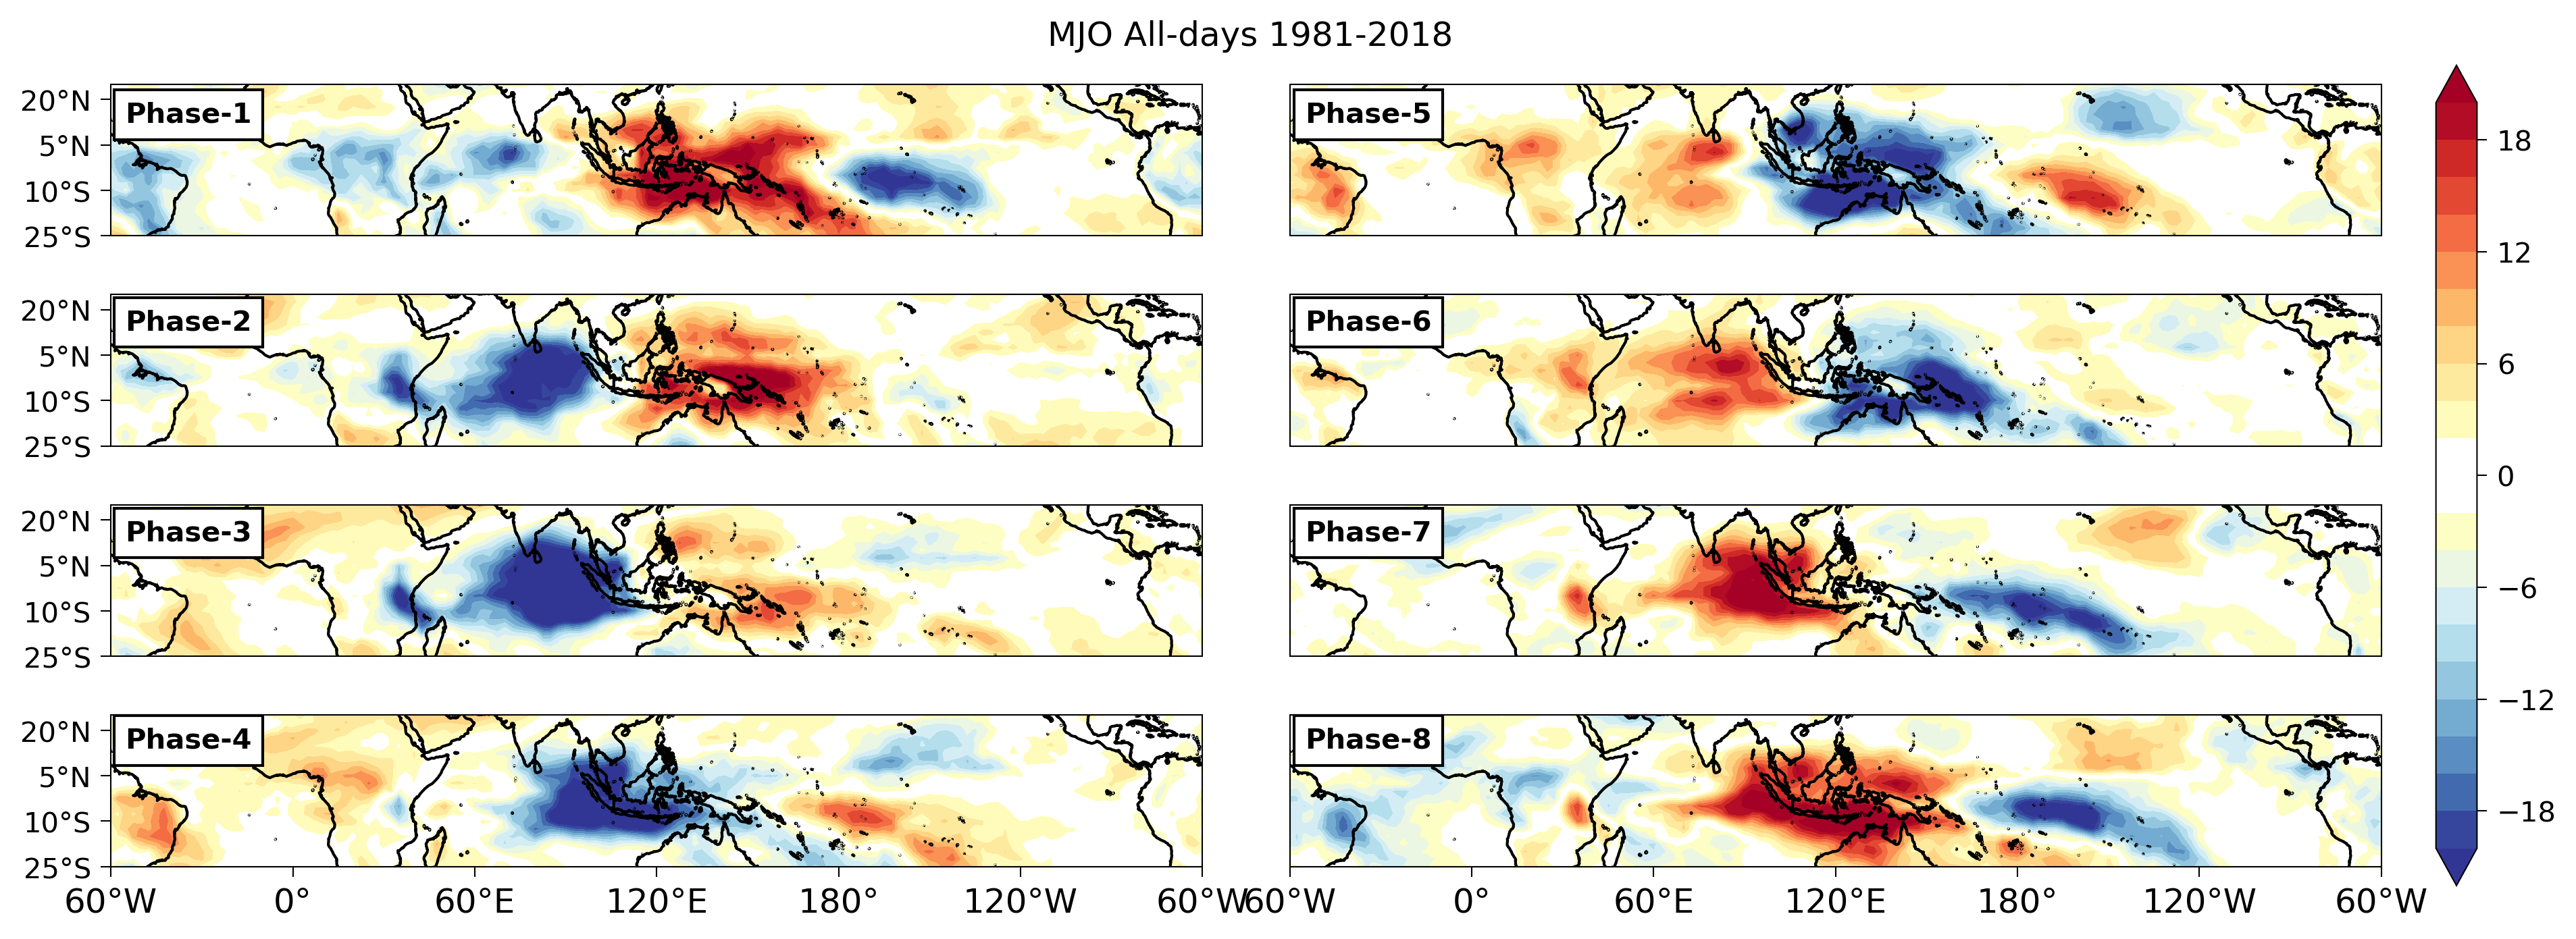

In [19]:
plot_composites(composites,cmap= tmap,title = 'MJO All-days 1981-2018', levels=np.arange(-20,21,2))

We have successfully plotted the life cycle of the MJO from phases 1 to 8 using the RMM index. We can compare the results with the result from MJO-Clivar below:

<center> <img src = https://www.ncl.ucar.edu/Applications/Images/mjoclivar_16_2_lg.png width = "400" height = "400" > </center>

https://www.ncl.ucar.edu/Applications/mjoclivar.shtml

Using these codes, you can experiment by changing the index. Several indices are available, such as OMI, VPM, ROMI, etc. Other indices can be found in the following link: https://www.psl.noaa.gov/mjo/mjoindex/. Moreover, you can also try to change the variables; moisture convergence and vertical moisture advection would be interesting to see :).

## Stage 3: MJO life-cycle during El-Nino/La-Nina

Now, we will plot the MJO during ENSO phases. First, we will get the Southern Oscillation Index (SOI) from the Bureau of Meteorology (http://www.bom.gov.au/climate/enso/soi/). We will use the method of Ghelani (2017), Cowan et al., (2023) and Dao et al., (2023). The Southern Oscillation Index is defined from the monthly mean sea level pressure difference between Tahiti and Darwin. 

<center> <img src = https://www.climate.gov/sites/default/files/Fig1_ENSOindices_SOI_large.png width = "400" height = "400" > </center>



source: https://www.climate.gov/sites/default/files/styles/full_width_620_alternate_image/public/Fig1_ENSOindices_SOI_610.png?itok=pc-ry47F

In [20]:
#get the soi index http://www.bom.gov.au/climate/enso/soi/

soi_csv = pd.read_csv('soi_monthly.txt',header=None)
soi_csv = soi_csv.rename(columns={0: 'date', 1: 'SOI'})
soi_csv

date   SOI
0     187601  11.3
1     187602  11.0
2     187603   0.2
3     187604   9.4
4     187605   6.8
...      ...   ...
1769  202306   0.2
1770  202307  -4.3
1771  202308 -12.7
1772  202309 -13.6
1773  202310  -6.8

[1774 rows x 2 columns]

Convert the date format into datetime for pandas

In [21]:
soi_csv['date'] = pd.to_datetime(soi_csv['date'],format='%Y%m')
soi_csv

date   SOI
0    1876-01-01  11.3
1    1876-02-01  11.0
2    1876-03-01   0.2
3    1876-04-01   9.4
4    1876-05-01   6.8
...         ...   ...
1769 2023-06-01   0.2
1770 2023-07-01  -4.3
1771 2023-08-01 -12.7
1772 2023-09-01 -13.6
1773 2023-10-01  -6.8

[1774 rows x 2 columns]

Smooth the SOI using the 3-month running mean.

In [22]:
#smooth the SOI using 3-month running mean
soi_smth = soi_csv.copy()
soi_smth['SOI'] = soi_csv['SOI'].rolling(3,center=True).mean()
soi_smth



date        SOI
0    1876-01-01        NaN
1    1876-02-01   7.500000
2    1876-03-01   6.866667
3    1876-04-01   5.466667
4    1876-05-01  11.133333
...         ...        ...
1769 2023-06-01  -7.533333
1770 2023-07-01  -5.600000
1771 2023-08-01 -10.200000
1772 2023-09-01 -11.033333
1773 2023-10-01        NaN

[1774 rows x 2 columns]

Resample the dataset from monthly to daily. 


In [23]:
soi_smth  = soi_smth.set_index(soi_smth['date'])
soi_daily = soi_smth.resample('1D').asfreq().ffill().reindex()
soi_daily

date        SOI
date                            
1876-01-01 1876-01-01        NaN
1876-01-02 1876-01-01        NaN
1876-01-03 1876-01-01        NaN
1876-01-04 1876-01-01        NaN
1876-01-05 1876-01-01        NaN
...               ...        ...
2023-09-27 2023-09-01 -11.033333
2023-09-28 2023-09-01 -11.033333
2023-09-29 2023-09-01 -11.033333
2023-09-30 2023-09-01 -11.033333
2023-10-01 2023-10-01 -11.033333

[53965 rows x 2 columns]

Choose the year for 1981-2018.


In [24]:
year = (soi_daily['date'] >= '1981-01-01') & (soi_daily['date'] <= '2018-12-31')
# year

In [25]:
soi_daily = soi_daily.loc[year]
soi_daily

date       SOI
date                           
1981-01-01 1981-01-01 -0.466667
1981-01-02 1981-01-01 -0.466667
1981-01-03 1981-01-01 -0.466667
1981-01-04 1981-01-01 -0.466667
1981-01-05 1981-01-01 -0.466667
...               ...       ...
2018-12-27 2018-12-01  2.866667
2018-12-28 2018-12-01  2.866667
2018-12-29 2018-12-01  2.866667
2018-12-30 2018-12-01  2.866667
2018-12-31 2018-12-01  2.866667

[13879 rows x 2 columns]

In [26]:
#get the season
soi_season = soi_daily[soi_daily.index.month.isin(monlist)]
soi_season

date       SOI
date                           
1981-01-01 1981-01-01 -0.466667
1981-01-02 1981-01-01 -0.466667
1981-01-03 1981-01-01 -0.466667
1981-01-04 1981-01-01 -0.466667
1981-01-05 1981-01-01 -0.466667
...               ...       ...
2018-12-27 2018-12-01  2.866667
2018-12-28 2018-12-01  2.866667
2018-12-29 2018-12-01  2.866667
2018-12-30 2018-12-01  2.866667
2018-12-31 2018-12-01  2.866667

[3429 rows x 2 columns]

Now, we set the threshold for El-Nino and La-Nina. Following Cowan et al, (2023) and Dao et al., (2023), we denote the day as El-Nino or La-Nina day if the SOI value is higher than 4 or lower than -4, respectively.

In [27]:

#lanina > 4 , elnino <-4, based on Cowan et al., (2023) and Dao et al., (2023)

enso_th = 4

#make a blank column
soi_season['Elnino'] = None
soi_season['Lanina'] = None

#loop the dates, assign 1 for ElNino/Lanina dats
enum = 0
for i in soi_season['SOI']:
    # print(i)
    # print(enum)
    if i >= enso_th:
        soi_season['Elnino'].iloc[enum]=0
        soi_season['Lanina'].iloc[enum]=1
    elif i <= -enso_th:
        soi_season['Lanina'].iloc[enum]=0
        soi_season['Elnino'].iloc[enum]=1
    else:
        soi_season['Lanina'].iloc[enum]=0
        soi_season['Elnino'].iloc[enum]=0
    enum = enum+1


In [28]:
rmm_season = rmm_season.set_index(rmm_season['yyyymmdd'])
soi_season['mjo_phase'] = rmm_season['phase'].tolist()

In [29]:
soi_season
# soi_season[soi_season['Lanina']==1]

date       SOI Elnino Lanina  mjo_phase
date                                                    
1981-01-01 1981-01-01 -0.466667      0      0        0.0
1981-01-02 1981-01-01 -0.466667      0      0        0.0
1981-01-03 1981-01-01 -0.466667      0      0        0.0
1981-01-04 1981-01-01 -0.466667      0      0        0.0
1981-01-05 1981-01-01 -0.466667      0      0        0.0
...               ...       ...    ...    ...        ...
2018-12-27 2018-12-01  2.866667      0      0        5.0
2018-12-28 2018-12-01  2.866667      0      0        5.0
2018-12-29 2018-12-01  2.866667      0      0        5.0
2018-12-30 2018-12-01  2.866667      0      0        5.0
2018-12-31 2018-12-01  2.866667      0      0        5.0

[3429 rows x 5 columns]

In [30]:
#make the data dictionary. 
date_phase_elnino = {}
for p in P:
    date_phase_elnino["phase-"+str(p)] = soi_season["date"].loc[(soi_season["mjo_phase"]==p) & (soi_season['Elnino']==1)]


#make the dictionary for El-Nino
composites_elnino = {}

print('MJO during El-Nino days')
for p in P:
    date = np.array(date_phase_elnino["phase-"+str(p)])
    composites_elnino["phase-"+str(p)] = olr_anom.sel(time=date).mean(dim="time")
    print(f'P{p}: n={len(date)}')

# composites_elnino

MJO during El-Nino days
P0: n=361
P1: n=59
P2: n=69
P3: n=113
P4: n=94
P5: n=75
P6: n=103
P7: n=146
P8: n=93


**Now, we plot the composites using the plotting function just like before.**

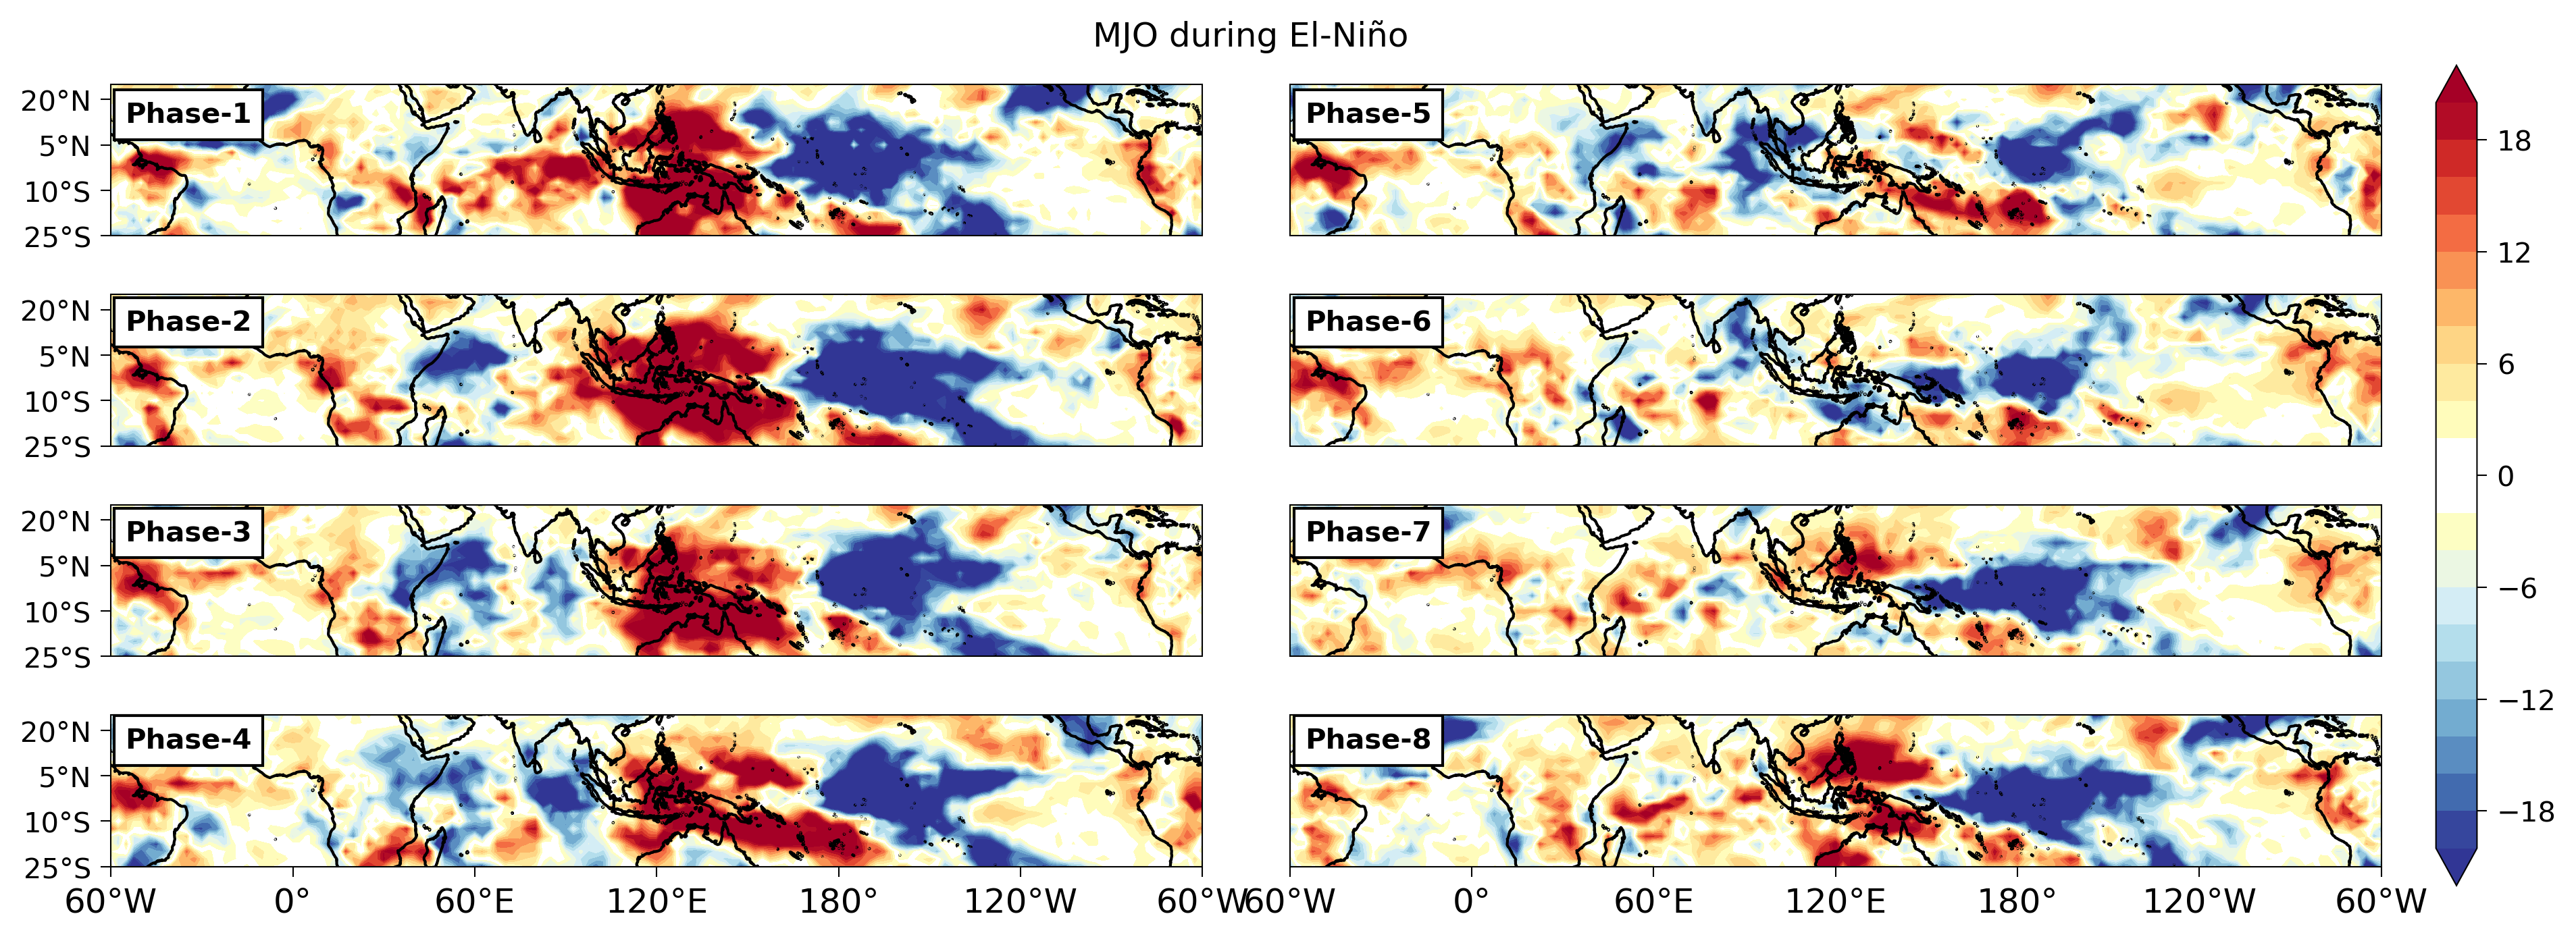

In [31]:
plot_composites(composites_elnino, namefig='MJO_nino_composite_raw.png', cmap=tmap,title='MJO during El-Niño', levels=np.arange(-20,21,2))

In [32]:
#again assign the date and make mean composites, but for La-Nina
date_phase_lanina = {}
for p in P:
    # print(p)
    date_phase_lanina["phase-"+str(p)] = soi_season["date"].loc[(soi_season["mjo_phase"]==p) & (soi_season['Lanina']==1)]
    
composites_lanina = {}

print('MJO during La-Nina days')
for p in P:
    date = np.array(date_phase_lanina["phase-"+str(p)])
    composites_lanina["phase-"+str(p)] = olr_anom.sel(time=date).mean(dim="time")
    #ndays for each phases
    print(f'P{p}: n={len(date)}')


MJO during La-Nina days
P0: n=351
P1: n=58
P2: n=66
P3: n=77
P4: n=76
P5: n=90
P6: n=95
P7: n=130
P8: n=79


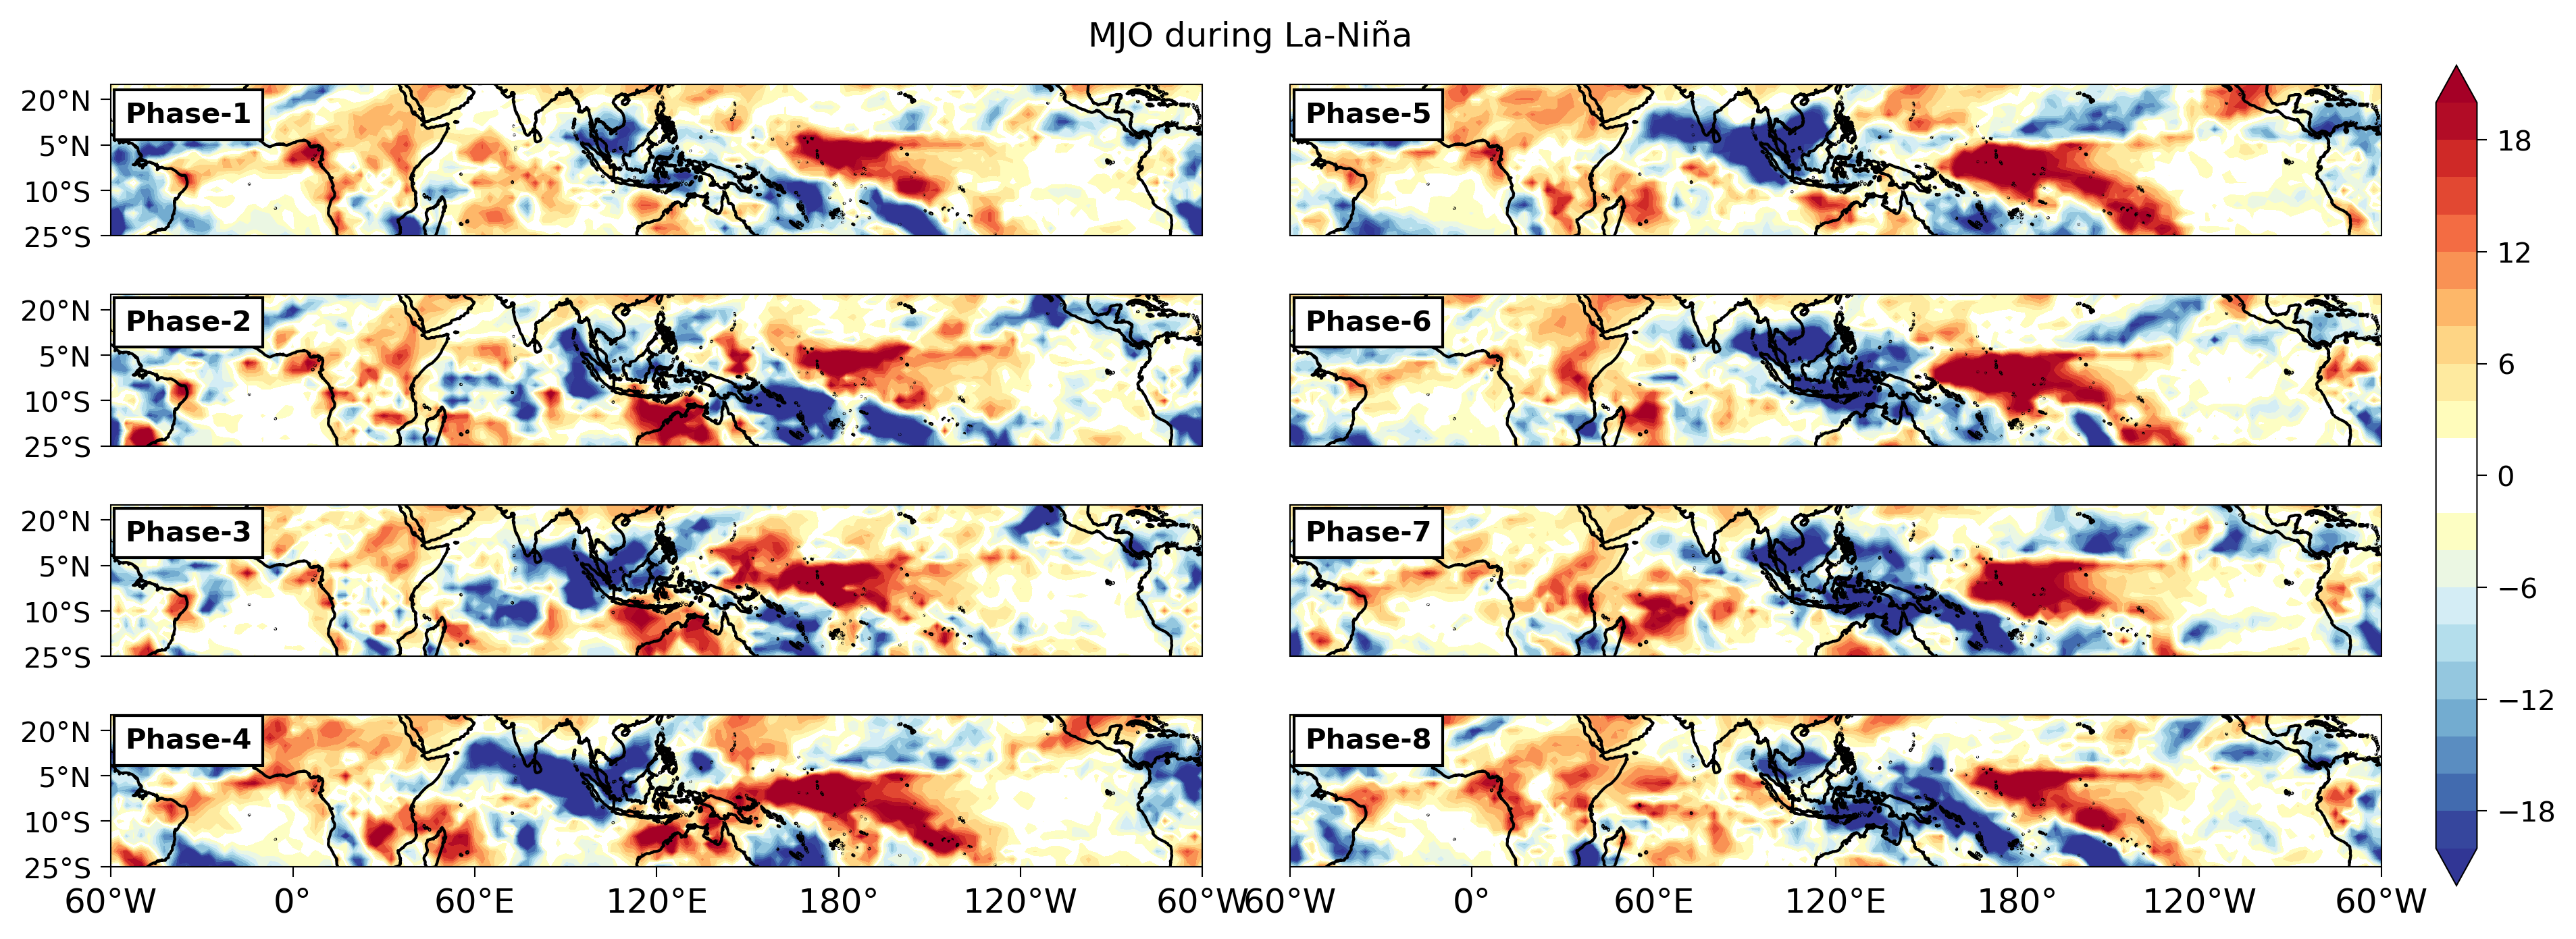

In [33]:
plot_composites(composites_lanina,namefig='MJO_nina_composite_raw.png',cmap=tmap,title='MJO during La-Niña', levels=np.arange(-20,21,2))

The relationship between ENSO and MJO is complex. The changes of background moisture convergence around the eastern MC during El-Niño/La-Niña days plays an important role on the MJO convective centre propagation (Hagos et al., 2019, DeMott et al., 2018, Feng et al., 2015). Feng et al., (2015) show that the moisture tendency ahead of the MJO convective centre is one of the factors responsible for the propagation of the MJO. A high positive moisture tendency ahead of the MJO will increase the likelihood of a propagating MJO and vice versa. 

Feng et al., (2015) suggest that the dry air intrusion from dry Equatorial Rossby waves (ER waves) dissipates the MJO convection, causing a negative moisture tendency ahead of the MJO convection during the non-propagating days. Further research by DeMott et al., (2018) elucidate what happens to these dry ER waves during the ENSO events. They found that ENSO regulates this dry air intrusion, which during El-Niño, the eastward shift of the warm pool over the Pacific reduces the background gradient moisture that promotes the dry ER waves generation. In this case, the horizontal moisture advection plays a dominating role in the MJO propagation (Kim et al., 2017). However, the dry air intrusion might also happen over the eastern Indian Ocean, which suggests that the occurrence of strong propagating MJO depends on whether the MJO survives the dry intrusion over the eastern Indian Ocean (DeMott et al., 2018). 

On the other hand, during La-Niña conditions, dry air intrusion over the eastern MC is more likely to occur and the propagation of the MJO is likely to depend on the moisture content of the MJO convective centre (DeMott et al., 2018). However, the La-Niña background moisture would promote the convection to propagate from the eastern Indan Ocean through the central part of the MC (DeMott et al., 2018). 


### Things to experiment on:

1. You can try to change the index for the MJO and/or ENSO event.
2. Change the threshold for ENSO days, Ghelani et al., (2017) use 7 as the threshold.
3. Try to assess other variables.
4. Try to see individual events instead of composites. 

### Finishing remarks

I think that's all from me. If you have any questions about this module you can contact me at:

fadhlilrizki@student.unimelb.edu.au
or
fadhlilrmuhammad@gmail.com

also, visit my LinkedIn (https://www.linkedin.com/in/fadhlil-rizki-muhammad-836852117/).

Hope that helps!

Cheers,
Fadhlil

## References

 
 Cowan, T., Wheeler, M. C., & Marshall, A. G. (2023). The combined influence of the Madden–Julian oscillation and El Niño–Southern Oscillation on Australian rainfall. Journal of Climate, 36(2), 313-334.
 
 Dao, T. L., Vincent, C. L., & Lane, T. P. (2023). Multiscale Influences on Rainfall in Northeast Australia. Journal of Climate, 36(17), 5989-6006.

 DeMott, C. A., Wolding, B. O., Maloney, E. D., & Randall, D. A. (2018). Atmospheric mechanisms for MJO decay over the Maritime Continent. Journal of Geophysical Research: Atmospheres, 123, 5188–5204. 
 
 Feng, J., Li, T., & Zhu, W. (2015). Propagating and nonpropagating MJO events over Maritime Continent. Journal of Climate, 28(21), 8430-8449.

 Hagos, S., Zhang, C., Leung, L. R., Burleyson, C. D., & Balaguru, K. (2019). A zonal migration of monsoon moisture flux convergence and the strength of Madden-Julian Oscillation events. Geophysical Research Letters, 46, 8554–8562. 
 
 Ghelani, R. P., Oliver, E. C., Holbrook, N. J., Wheeler, M. C., & Klotzbach, P. J. (2017). Joint modulation of Intraseasonal rainfall in tropical Australia by the Madden‐Julian oscillation and El Niño‐southern oscillation. Geophysical Research Letters, 44(20), 10-754.

 Kim, D., Kim, H., & Lee, M.-I. (2017). Why does the MJO detour the Maritime Continent during austral summer?. Geophysical Research Letters, 44, 2579–2587. 

 Wheeler, M. C., & Hendon, H. H. (2004). An all-season real-time multivariate MJO index: Development of an index for monitoring and prediction. Monthly weather review, 132(8), 1917-1932.
